In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_human_def.h5',
                               '--exp-name', 'baseline_Melania_Erythroid_human',
                               '--model-name', 'baseline_tmp.cpt',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Early Erythroid", "Mid  Erythroid"), ('Mid  Erythroid', "Late Erythroid")]
k_cluster = "type2"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt"):
    torch.autograd.set_detect_anomaly(True)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
        
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, 
                             xyids=[0, 1],
                             device=device,
                             )
        
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_human/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity')
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')

print(adata)

AnnData object with n_obs × n_vars = 35877 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'type', 'samp', 'leiden', 'type2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'leiden', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params', 'type2_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'stc_velocity', 'unspliced', 'variance_stc_velocity'
    obsp: 'connectivities', 'distances'


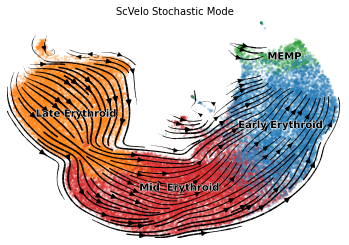

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.081447646, ('Mid  Erythroid', 'Late Erythroid'): 0.04631139}
Total Mean: 0.06387951970100403
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.7524644, ('Mid  Erythroid', 'Late Erythroid'): 0.8911031}
Total Mean: 0.8217837810516357
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.3915759926120027, ('Mid  Erythroid', 'Late Erythroid'): -0.659077433493216}
Total Mean: -0.5253267130526094
# In-cluster Coherence
{'Early Erythroid': 0.84404796, 'Late Erythroid': 0.93301064, 'MEMP': 0.94228786, 'Mid  Erythroid': 0.85356015}
Total Mean: 0.893226683139801
# In-cluster Confidence
{'Early Erythroid': 0.8211951176751143, 'Late Erythroid': 0.9371989427152257, 'MEMP': 0.9497227164934267, 'Mid  Erythroid': 0.8122398725342098}
Total Mean: 0.8800891623544941


In [7]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity", x_emb="X_umap")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 5767.795410
Train Epoch: 200/20000 	Loss: 5753.235352
Train Epoch: 300/20000 	Loss: 5746.833496
Train Epoch: 400/20000 	Loss: 5742.664062
Train Epoch: 500/20000 	Loss: 5739.420898
Train Epoch: 600/20000 	Loss: 5736.668945
Train Epoch: 700/20000 	Loss: 5734.181641
Train Epoch: 800/20000 	Loss: 5731.873535
Train Epoch: 900/20000 	Loss: 5728.930664
Train Epoch: 1000/20000 	Loss: 5725.781738
Train Epoch: 1100/20000 	Loss: 5722.710449
Train Epoch: 1200/20000 	Loss: 5719.645020
Train Epoch: 1300/20000 	Loss: 5716.449219
Train Epoch: 1400/20000 	Loss: 5713.056152
Train Epoch: 1500/20000 	Loss: 5709.605469
Train Epoch: 1600/20000 	Loss: 5705.866699
Train Epoch: 1700/20000 	Loss: 5701.883301
Train Epoch: 1800/20000 	Loss: 5697.828613
Train Epoch: 1900/20000 	Loss: 5693.546387
Train Epoch: 2000/20000 	Loss: 5688.881836
Train Epoch: 2100/20000 	Loss: 5684.168945
Train Epoch: 2200/20000 	Loss: 5679.274414
Train Epoch: 2300/20000 	Loss: 5674.217285
Train Epoch: 2400/20

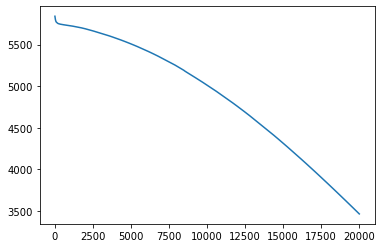

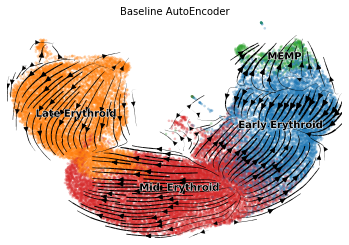

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.1310441, ('Mid  Erythroid', 'Late Erythroid'): 0.23978376}
Total Mean: 0.1854139268398285
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.9075248, ('Mid  Erythroid', 'Late Erythroid'): 0.8638643}
Total Mean: 0.8856945633888245
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.29605589594342746, ('Mid  Erythroid', 'Late Erythroid'): 0.21052692508342719}
Total Mean: -0.04276448543000014
# In-cluster Coherence
{'Early Erythroid': 0.8019319, 'Late Erythroid': 0.8488484, 'MEMP': 0.8996997, 'Mid  Erythroid': 0.9466005}
Total Mean: 0.8742700815200806
# In-cluster Confidence
{'Early Erythroid': 0.8616770937782734, 'Late Erythroid': 0.852037979950493, 'MEMP': 0.7122610134359613, 'Mid  Eryth

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    args.lr = 1e-3
    model = get_baseline_AE(in_dim, z_dim, h_dim, True).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95],
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 5686.987305
Train Epoch: 200/20000 	Loss: 5541.192871
Train Epoch: 300/20000 	Loss: 5170.457520
Train Epoch: 400/20000 	Loss: 4285.197754
Train Epoch: 500/20000 	Loss: 2576.590820
Train Epoch: 600/20000 	Loss: 827.742920
Train Epoch: 700/20000 	Loss: 234.804733
Train Epoch: 800/20000 	Loss: 151.018188
Train Epoch: 900/20000 	Loss: 137.945389
Train Epoch: 1000/20000 	Loss: 134.331329
Train Epoch: 1100/20000 	Loss: 132.179123
Train Epoch: 1200/20000 	Loss: 130.119186
Train Epoch: 1300/20000 	Loss: 127.814636
Train Epoch: 1400/20000 	Loss: 125.062538
Train Epoch: 1500/20000 	Loss: 121.700653
Train Epoch: 1600/20000 	Loss: 117.538834
Train Epoch: 1700/20000 	Loss: 112.359390
Train Epoch: 1

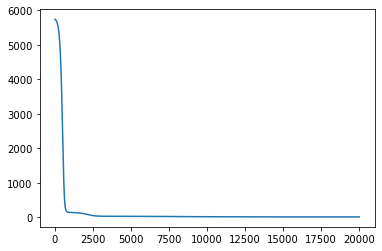

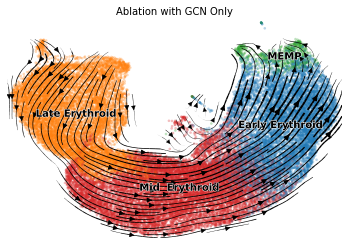

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.021374198, ('Mid  Erythroid', 'Late Erythroid'): 0.045123715}
Total Mean: 0.03324895724654198
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.99995935, ('Mid  Erythroid', 'Late Erythroid'): 0.9998885}
Total Mean: 0.9999239444732666
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.5077709656532916, ('Mid  Erythroid', 'Late Erythroid'): -0.3854741524210369}
Total Mean: -0.44662255903716425
# In-cluster Coherence
{'Early Erythroid': 0.9999852, 'Late Erythroid': 0.9999094, 'MEMP': 0.9999965, 'Mid  Erythroid': 0.99995214}
Total Mean: 0.9999607801437378
# In-cluster Confidence
{'Early Erythroid': 0.999981554099548, 'Late Erythroid': 0.9999087962515997, 'MEMP': 0.9999932078445483, 'Mid  

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    args.lr = 1e-4
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 5760.342773
Train Epoch: 200/20000 	Loss: 5747.682617
Train Epoch: 300/20000 	Loss: 5742.364746
Train Epoch: 400/20000 	Loss: 5739.145020
Train Epoch: 500/20000 	Loss: 5737.157715
Train Epoch: 600/20000 	Loss: 5735.749023
Train Epoch: 700/20000 	Loss: 5734.622559
Train Epoch: 800/20000 	Loss: 5733.687500
Train Epoch: 900/20000 	Loss: 5732.868652
Train Epoch: 1000/20000 	Loss: 5732.071777
Train Epoch: 1100/20000 	Loss: 5731.340820
Train Epoch: 1200/20000 	Loss: 5730.682617
Train Epoch: 1300/20000 	Loss: 5729.974121
Train Epoch: 1400/20000 	Loss: 5729.325684
Train Epoch: 1500/20000 	Loss: 5728.534668
Train Epoch: 1600/20000 	Loss: 5727.912598
Train Epoch: 1700/20000 	Loss: 5727.211914
Train Epoch: 1800/20000 	Loss: 5726.644043
Train Epoch: 1900/20000 	Loss: 5726.077637
Train Epoch: 2000/20000 	Loss: 5725.519531
Train Epoch: 2100/20000 	Loss: 5725.041992
Train Epoch: 2200/20000 	Loss: 5733.163574
Train Epoch: 2300/20000 	Loss: 5730.212891
Train Epoch: 2400/20

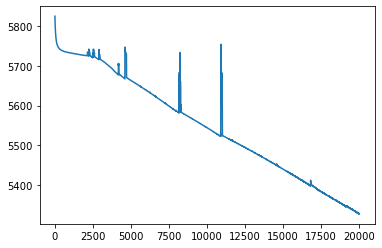

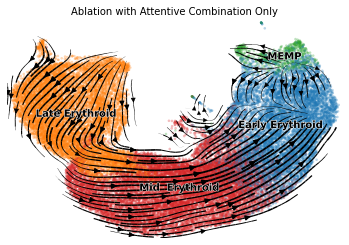

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.08905169, ('Mid  Erythroid', 'Late Erythroid'): 0.15113842}
Total Mean: 0.12009505927562714
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.9493167, ('Mid  Erythroid', 'Late Erythroid'): 0.9726282}
Total Mean: 0.9609724283218384
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.49954967797763916, ('Mid  Erythroid', 'Late Erythroid'): -0.21819899559266925}
Total Mean: -0.35887433678515424
# In-cluster Coherence
{'Early Erythroid': 0.96882814, 'Late Erythroid': 0.9781704, 'MEMP': 0.98046017, 'Mid  Erythroid': 0.97970665}
Total Mean: 0.9767913818359375
# In-cluster Confidence
{'Early Erythroid': 0.9629537493980922, 'Late Erythroid': 0.9735457399718743, 'MEMP': 0.9621579286437365, 'Mid

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    args.lr = 1e-4
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device,
        True
    )
    
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95],
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:09) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:08) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


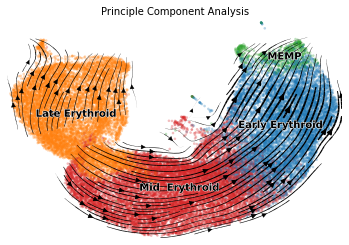

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.13002008, ('Mid  Erythroid', 'Late Erythroid'): 0.1821657}
Total Mean: 0.15609288215637207
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.9432272, ('Mid  Erythroid', 'Late Erythroid'): 0.70453215}
Total Mean: 0.8238796591758728
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.4923570901602218, ('Mid  Erythroid', 'Late Erythroid'): -0.4032534070805035}
Total Mean: -0.44780524862036264
# In-cluster Coherence
{'Early Erythroid': 0.9487526, 'Late Erythroid': 0.723625, 'MEMP': 0.9184291, 'Mid  Erythroid': 0.8866593}
Total Mean: 0.8693665266036987
# In-cluster Confidence
{'Early Erythroid': 0.9448739772029812, 'Late Erythroid': 0.7170945222306615, 'MEMP': 0.890439742035086, 'Mid  Eryth

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:10) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:09) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


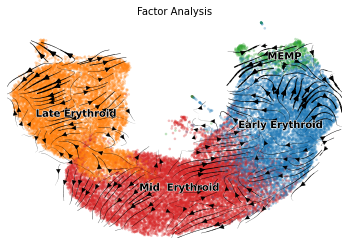

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.027180517, ('Mid  Erythroid', 'Late Erythroid'): 0.023066616}
Total Mean: 0.025123566389083862
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.15504770302557375, ('Mid  Erythroid', 'Late Erythroid'): 0.08487199312879234}
Total Mean: 0.11995984807718305
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.012286439189689205, ('Mid  Erythroid', 'Late Erythroid'): -0.215264107480376}
Total Mean: -0.1014888341453434
# In-cluster Coherence
{'Early Erythroid': 0.25024272097070477, 'Late Erythroid': 0.22559113236332212, 'MEMP': 0.30164717616391984, 'Mid  Erythroid': 0.2444792151712355}
Total Mean: 0.25549006116729556
# In-cluster Confidence
{'Early Erythroid': 0.24825842180299748, 'Late Eryth

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)